In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import shap
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [2]:
train_target = pd.read_csv('D:/Data/KAERI_dataset/train_target.csv')
targets = list(train_target.columns)[1:]

def cutoff_features(data,cutoff):
    feature_list = list(data.loc[:,'Time':'RMS_time'].columns) 
    if cutoff > 0:
        for s in ['S1','S2','S3','S4']:
            feature_list = feature_list+[s+'_f'+str(n) for n in range(cutoff)]
    return feature_list

In [3]:
select_objective = 'regression'
boosting_type = 'dart'
learning_rate = [0.21,0.36,0.2,0.25]

x_params = {'learning_rate':learning_rate[0],'n_estimators':1000,
    'boosting_type':boosting_type,'random_state':2,'objective':select_objective
}
y_params = {'learning_rate':learning_rate[1],'n_estimators':1000,
    'boosting_type':boosting_type,'random_state':2,'objective':select_objective
}
m_params = {'learning_rate':learning_rate[2],'n_estimators':1000,
    'boosting_type':boosting_type,'random_state':2,'objective':select_objective
}
v_params = {'learning_rate':learning_rate[3],'n_estimators':1000,
    'boosting_type':boosting_type,'random_state':2,'objective':select_objective
}

In [4]:
file_name_df = 'pickle_file/KAERI_df.pickle' 

with open(file_name_df, 'rb') as frb:
    df = pickle.load(frb)

# 데이터를 학습용, 검증용으로 분리
df_train_val, df_test = train_test_split(df[1:],test_size=0.2,train_size=0.8,random_state=2)

print(df_train_val.shape, df_test.shape, df.shape)

simple_features = np.array(df.loc[:,'Time':'RMS_time'].columns)
print(len(simple_features))

(2239, 358) (560, 358) (2800, 358)
33


In [5]:
x_features = cutoff_features(df,cutoff=0)
y_features = cutoff_features(df,cutoff=0)
m_features = cutoff_features(df,cutoff=35)
v_features = cutoff_features(df,cutoff=70)

print("tot_num_of_feature :",np.array([len(x_features),len(y_features),len(m_features),len(v_features)]).max())

tot_num_of_feature : 313


In [6]:
file_name_model = 'pickle_file/KAERI_lgb_model.pickle' 

with open(file_name_model, 'rb') as frb:
    model = pickle.load(frb)

In [7]:
mae_score = mean_absolute_error(df_test[targets],model['submit'])
rmse_score = mean_squared_error(df_test[targets],model['submit'])**0.5

print('Test_pred -','MAE:',mae_score,'RMSE:',rmse_score)
#(선택) M_cutoff=35, V_cutoff=70, RMS모두 추가
# MAE: 1.2990126029084295 RMSE: 4.149042379994915

Test_pred - MAE: 1.2990126029084295 RMSE: 4.149042379994915


In [8]:
x_mae_score = mean_absolute_error(df_test['X'],model['submit']['X'])
x_rmse_score = mean_squared_error(df_test['X'],model['submit']['X'])**0.5

y_mae_score = mean_absolute_error(df_test['Y'],model['submit']['Y'])
y_rmse_score = mean_squared_error(df_test['Y'],model['submit']['Y'])**0.5

m_mae_score = mean_absolute_error(df_test['M'],model['submit']['M'])
m_rmse_score = mean_squared_error(df_test['M'],model['submit']['M'])**0.5

v_mae_score = mean_absolute_error(df_test['V'],model['submit']['V'])
v_rmse_score = mean_squared_error(df_test['V'],model['submit']['V'])**0.5

test_score = pd.DataFrame((
    ['MAE',x_mae_score,y_mae_score,m_mae_score,v_mae_score],
    ['RMSE',x_rmse_score,y_rmse_score,m_rmse_score,v_rmse_score],
    ['std']+list(df_test[targets].std())),
    columns=['test_score','X','Y','M','V']
    )
test_score = test_score.set_index('test_score')
test_score.loc['RMSE/std'] = test_score.loc['RMSE']/test_score.loc['std']
test_score
#(선택) M_cutoff=35, V_cutoff=70, RMS모두 추가
# 	        X       	Y       	M       	V
# MAE	1.008558	0.414540	3.765445	0.007507
# RMSE	5.783727	1.940956	5.624863	0.017871
# std	269.882749	257.932606	49.448930	0.282387
# RMSE/std	0.021431	0.007525	0.113751	0.063287

X           Y          M         V
test_score                                             
MAE           1.008558    0.414540   3.765445  0.007507
RMSE          5.783727    1.940956   5.624863  0.017871
std         269.882749  257.932606  49.448930  0.282387
RMSE/std      0.021431    0.007525   0.113751  0.063287

In [9]:
explainer_x = shap.TreeExplainer(model['X'])
shap_values_x = explainer_x.shap_values(df_train_val[x_features])
explainer_y = shap.TreeExplainer(model['Y'])
shap_values_y = explainer_y.shap_values(df_train_val[y_features])
explainer_m = shap.TreeExplainer(model['M'])
shap_values_m = explainer_m.shap_values(df_train_val[m_features])
explainer_v = shap.TreeExplainer(model['V'])
shap_values_v = explainer_v.shap_values(df_train_val[v_features])

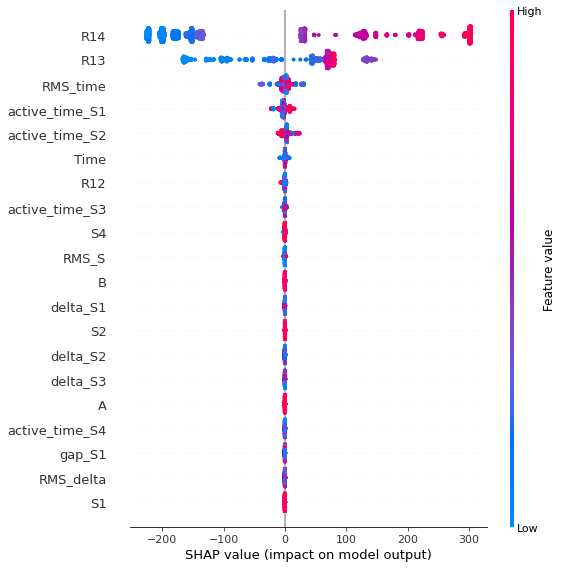

In [10]:
shap.summary_plot(shap_values_x, df_train_val[x_features])

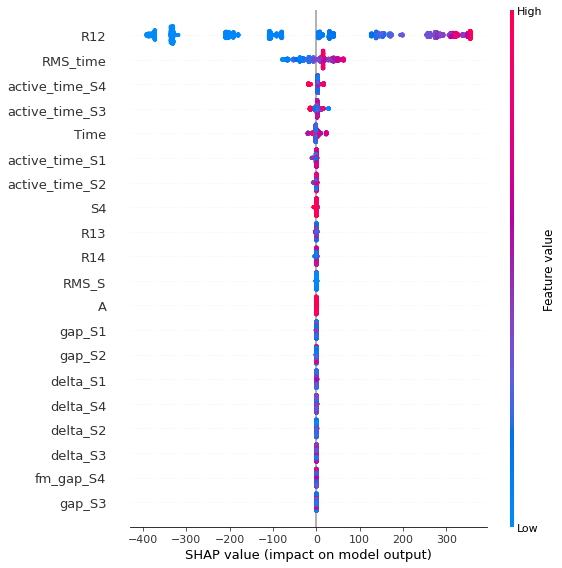

In [11]:
shap.summary_plot(shap_values_y, df_train_val[y_features])

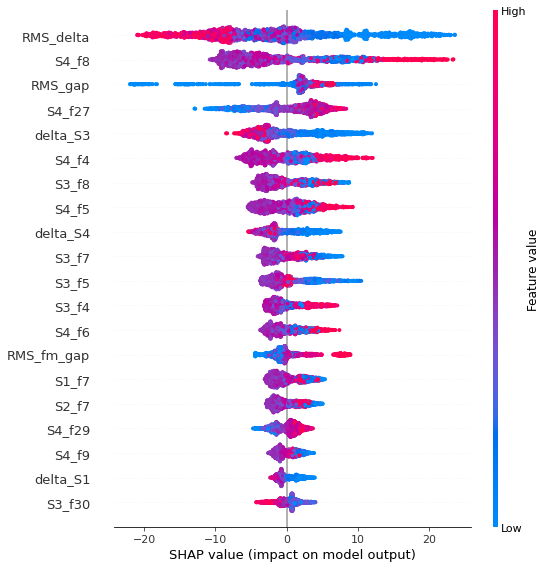

In [12]:
shap.summary_plot(shap_values_m, df_train_val[m_features])

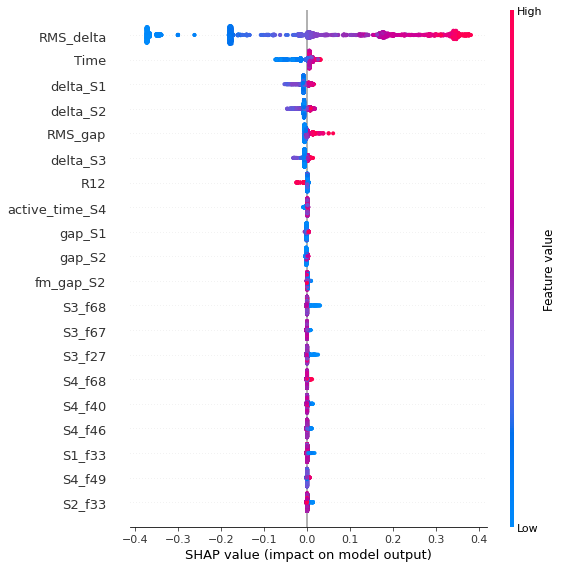

In [13]:
shap.summary_plot(shap_values_v, df_train_val[v_features])

In [14]:
# opt_cutoff_x = find_opt_cutoff('X',m_params,train_features,train_target,min_c=0,max_c=100)
# # mean_rmse + std_rmse 가 제일 작은걸 찾아보면, cutoff=0일때다. 즉 안쓰는게 낫다!

# opt_cutoff_y = find_opt_cutoff('Y',m_params,train_features,train_target,min_c=0,max_c=100)
# # mean_rmse + std_rmse 가 제일 작은걸 찾아보면, cutoff=5일때다. 
# # 헌데, 이 경우에는 mae평균 차이가 크고, rmse평균도 차이가 너무 많이 난다. 애매...
# # x와 동일하게 cutoff=0으로 세팅

# opt_cutoff_m = find_opt_cutoff('M',m_params,train_features,train_target,min_c=0,max_c=100)
# # mean_rmse + std_rmse 가 제일 작은걸 찾아보면, cutoff=35일때다

# opt_cutoff_v = find_opt_cutoff('V',v_params,train_features,train_target,min_c=0,max_c=100)
# # mean_rmse + std_rmse 가 제일 작은걸 찾아보면, cutoff=70일때다

In [15]:
check_id = 774 # 1353 # 2742 # 1756
shap_values_xx = explainer_x.shap_values(df_test.loc[[check_id],x_features])

shap.initjs()
shap.force_plot(
    base_value=explainer_x.expected_value, 
    shap_values=shap_values_xx,
    features=df_test.loc[[check_id],x_features]
)

In [16]:
check_id = 1353 # 2742 # 1756
shap_values_xx = explainer_x.shap_values(df_test.loc[[check_id],x_features])

shap.initjs()
shap.force_plot(
    base_value=explainer_x.expected_value, 
    shap_values=shap_values_xx,
    features=df_test.loc[[check_id],x_features]
)

In [17]:
check_id = 2742 # 1756
shap_values_xx = explainer_x.shap_values(df_test.loc[[check_id],x_features])

shap.initjs()
shap.force_plot(
    base_value=explainer_x.expected_value, 
    shap_values=shap_values_xx,
    features=df_test.loc[[check_id],x_features]
)

In [18]:
check_id = 1756
shap_values_xx = explainer_x.shap_values(df_test.loc[[check_id],x_features])

shap.initjs()
shap.force_plot(
    base_value=explainer_x.expected_value, 
    shap_values=shap_values_xx,
    features=df_test.loc[[check_id],x_features]
)

In [19]:
check_id = 512 # 1765 # 2742 # 774 
shap_values_yy = explainer_y.shap_values(df_test.loc[[check_id],y_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_y.expected_value, 
    shap_values=shap_values_yy,
    features=df_test.loc[[check_id],y_features]
)

In [20]:
check_id = 1765 # 2742 # 774 
shap_values_yy = explainer_y.shap_values(df_test.loc[[check_id],y_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_y.expected_value, 
    shap_values=shap_values_yy,
    features=df_test.loc[[check_id],y_features]
)

In [21]:
check_id = 2742 # 774 
shap_values_yy = explainer_y.shap_values(df_test.loc[[check_id],y_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_y.expected_value, 
    shap_values=shap_values_yy,
    features=df_test.loc[[check_id],y_features]
)

In [22]:
check_id = 774 
shap_values_yy = explainer_y.shap_values(df_test.loc[[check_id],y_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_y.expected_value, 
    shap_values=shap_values_yy,
    features=df_test.loc[[check_id],y_features]
)

In [23]:
check_id = 2403 #2315 # 857 #69 
shap_values_mm = explainer_m.shap_values(df_test.loc[[check_id],m_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_m.expected_value, 
    shap_values=shap_values_mm,
    features=df_test.loc[[check_id],m_features]
)

In [24]:
check_id = 2315 # 857 #69 
shap_values_mm = explainer_m.shap_values(df_test.loc[[check_id],m_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_m.expected_value, 
    shap_values=shap_values_mm,
    features=df_test.loc[[check_id],m_features]
)

In [25]:
check_id =857 #69 
shap_values_mm = explainer_m.shap_values(df_test.loc[[check_id],m_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_m.expected_value, 
    shap_values=shap_values_mm,
    features=df_test.loc[[check_id],m_features]
)

In [26]:
check_id = 69 
shap_values_mm = explainer_m.shap_values(df_test.loc[[check_id],m_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_m.expected_value, 
    shap_values=shap_values_mm,
    features=df_test.loc[[check_id],m_features]
)

In [27]:
check_id = 2377 #1771 #2328 #2403 
shap_values_vv = explainer_v.shap_values(df_test.loc[[check_id],v_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_v.expected_value, 
    shap_values=shap_values_vv,
    features=df_test.loc[[check_id],v_features]
)

In [28]:
check_id = 1771 #2328 #2403 
shap_values_vv = explainer_v.shap_values(df_test.loc[[check_id],v_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_v.expected_value, 
    shap_values=shap_values_vv,
    features=df_test.loc[[check_id],v_features]
)

In [29]:
check_id = 2328 #2403 
shap_values_vv = explainer_v.shap_values(df_test.loc[[check_id],v_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_v.expected_value, 
    shap_values=shap_values_vv,
    features=df_test.loc[[check_id],v_features]
)

In [30]:
check_id = 2403 
shap_values_vv = explainer_v.shap_values(df_test.loc[[check_id],v_features])

shap.initjs();
shap.force_plot(
    base_value=explainer_v.expected_value, 
    shap_values=shap_values_vv,
    features=df_test.loc[[check_id],v_features]
)

In [31]:
shap.initjs();

feature_x1 = 'R14'
feature_x2 = 'R13'

feature_y1 = 'R12'
feature_y2 = 'RMS_time'

feature_m1 = 'RMS_delta'
feature_m2 = 'S4_f8' #'RMS_gap'

feature_v1 = 'RMS_delta'
feature_v2 = 'Time'


isolated_x1 = pdp_isolate(
    feature=feature_x1, model=model['X'], dataset=df_train_val[x_features],
    model_features=x_features, grid_type='percentile', num_grid_points=10
    )
isolated_x2 = pdp_isolate(
    feature=feature_x2, model=model['X'], dataset=df_train_val[x_features],
    model_features=x_features, grid_type='percentile', num_grid_points=10
    )

isolated_y1 = pdp_isolate(
    feature=feature_y1, model=model['Y'], dataset=df_train_val[y_features],
    model_features=y_features, grid_type='percentile', num_grid_points=10
    )
isolated_y2 = pdp_isolate(
    feature=feature_y2, model=model['Y'], dataset=df_train_val[y_features],
    model_features=y_features, grid_type='percentile', num_grid_points=10
    )

isolated_m1 = pdp_isolate(
    feature=feature_m1, model=model['M'], dataset=df_train_val[m_features],
    model_features=m_features, grid_type='percentile', num_grid_points=10
    )
isolated_m2 = pdp_isolate(
    feature=feature_m2, model=model['M'], dataset=df_train_val[m_features],
    model_features=m_features, grid_type='percentile', num_grid_points=10
    )

isolated_v1 = pdp_isolate(
    feature=feature_v1, model=model['V'], dataset=df_train_val[v_features],
    model_features=v_features, grid_type='percentile', num_grid_points=10
    )
isolated_v2 = pdp_isolate(
    feature=feature_v2, model=model['V'], dataset=df_train_val[v_features],
    model_features=v_features, grid_type='percentile', num_grid_points=10
    )

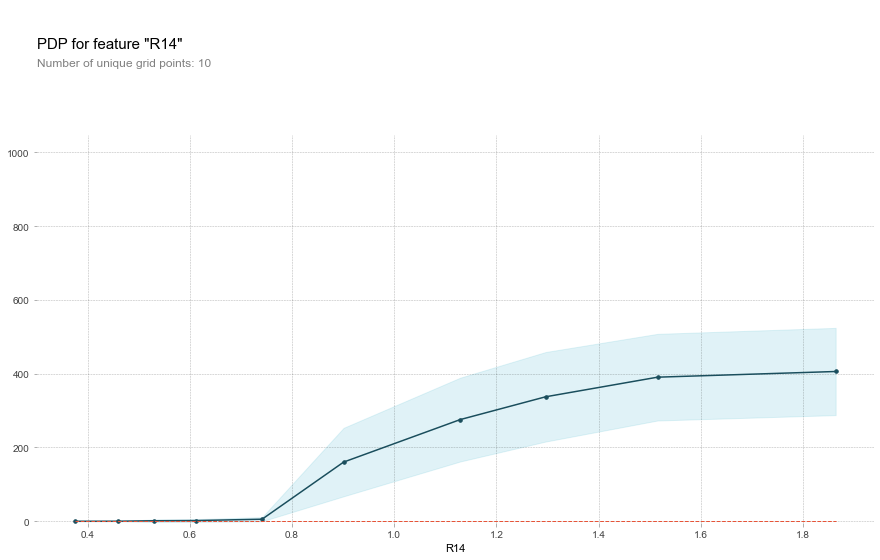

In [32]:
pdp_plot(isolated_x1, feature_name=feature_x1);

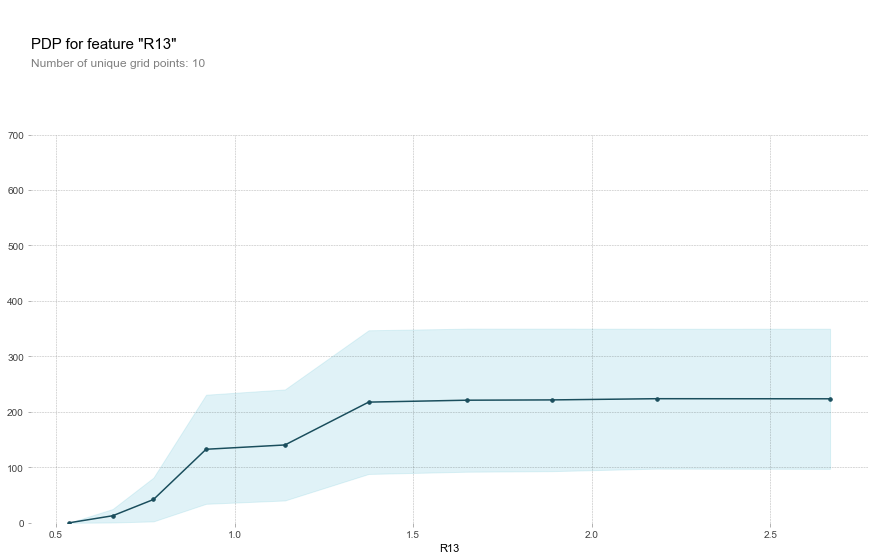

In [33]:
pdp_plot(isolated_x2, feature_name=feature_x2);

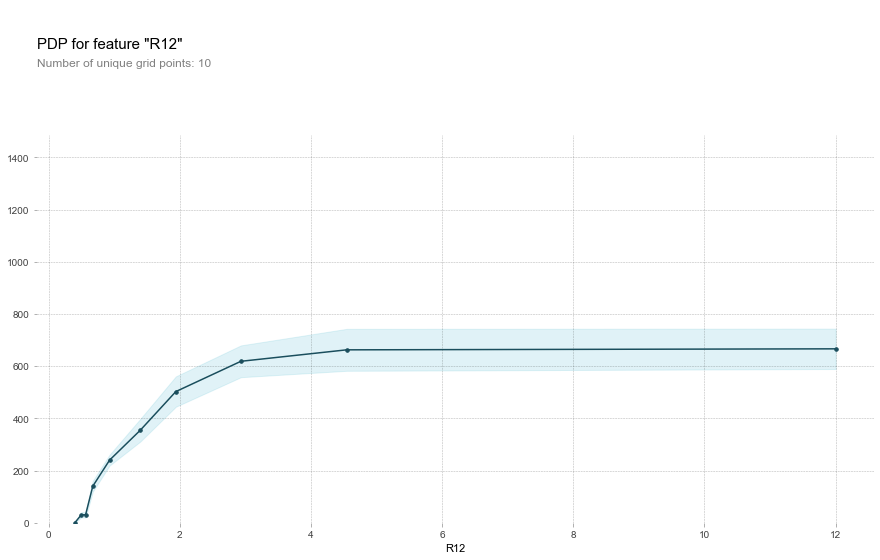

In [34]:
pdp_plot(isolated_y1, feature_name=feature_y1);

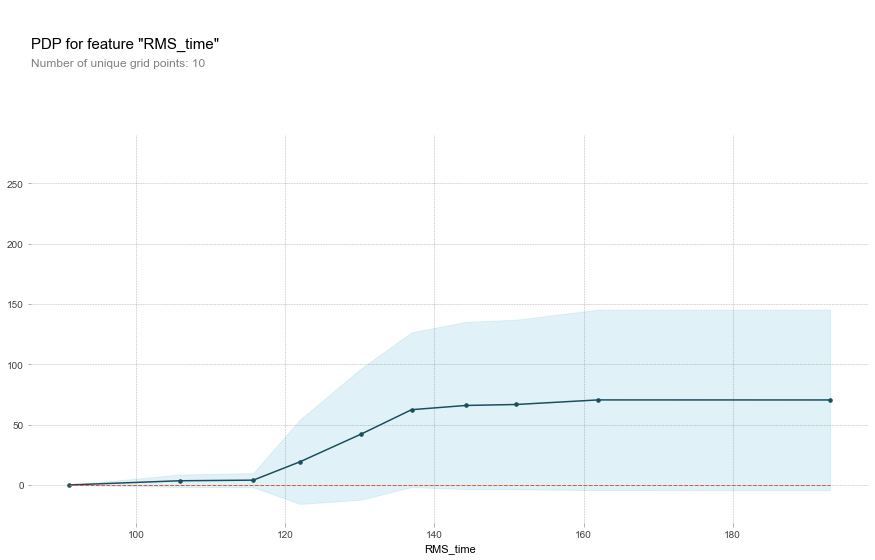

In [35]:
pdp_plot(isolated_y2, feature_name=feature_y2);

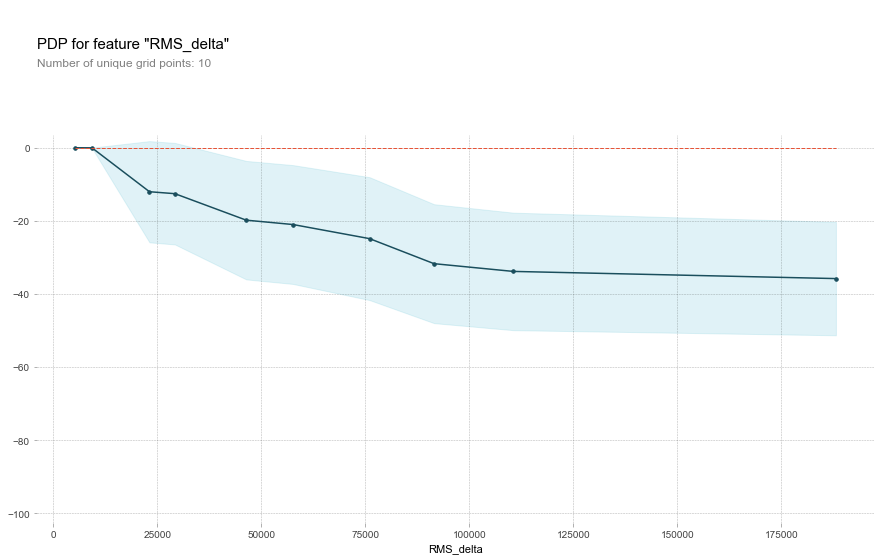

In [36]:
pdp_plot(isolated_m1, feature_name=feature_m1);

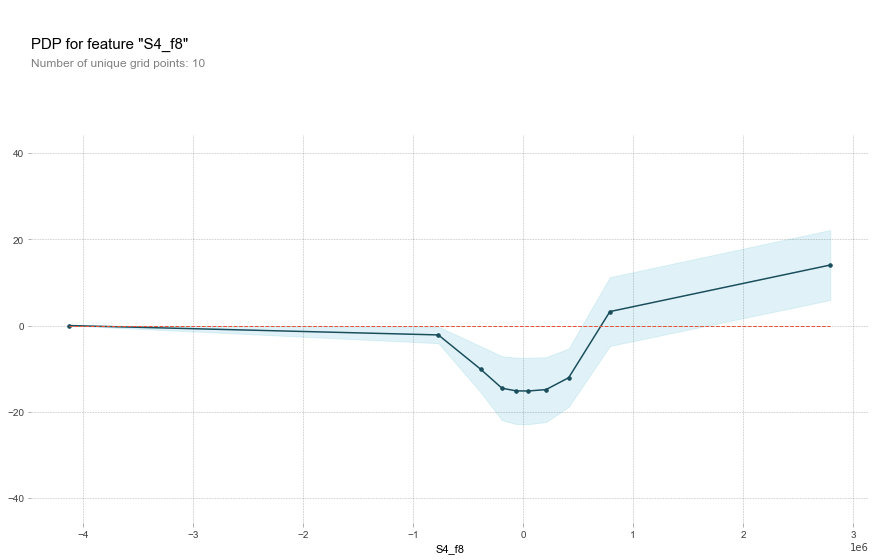

In [37]:
pdp_plot(isolated_m2, feature_name=feature_m2);

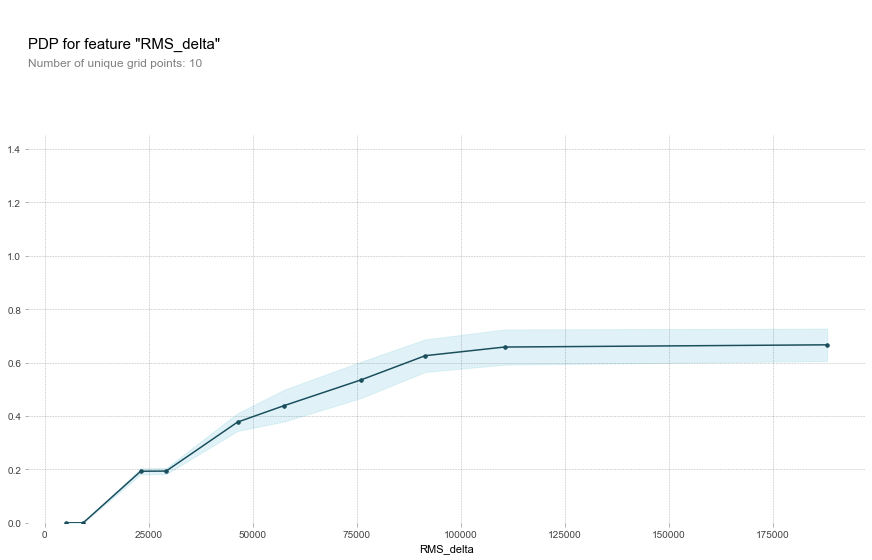

In [38]:
pdp_plot(isolated_v1, feature_name=feature_v1);

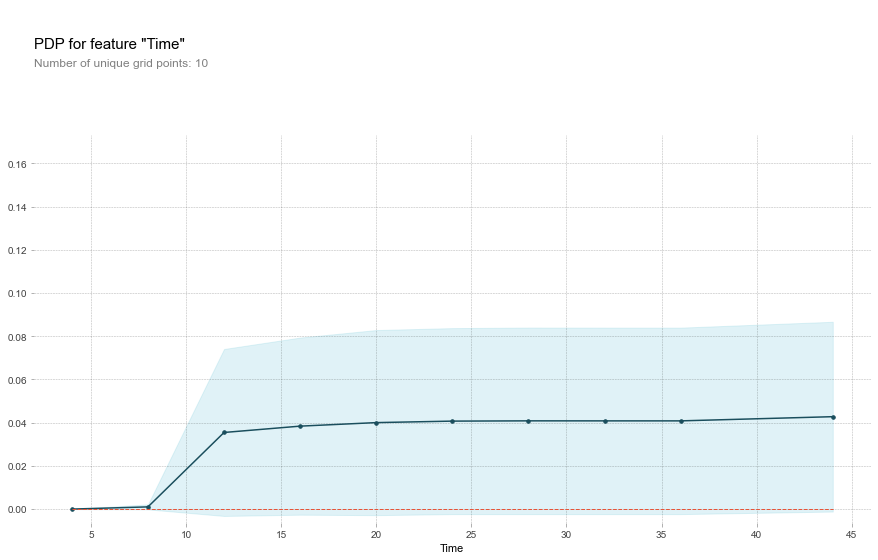

In [39]:
pdp_plot(isolated_v2, feature_name=feature_v2);

In [40]:
interaction_x = pdp_interact(
    model=model['X'], 
    dataset=df_train_val[x_features],
    model_features=x_features, 
    features=[feature_x1,feature_x2]
)

interaction_y = pdp_interact(
    model=model['Y'], 
    dataset=df_train_val[y_features],
    model_features=y_features, 
    features=[feature_y1,feature_y2]
)

interaction_m = pdp_interact(
    model=model['M'], 
    dataset=df_train_val[m_features],
    model_features=m_features, 
    features=[feature_m1,feature_m2]
)

interaction_v = pdp_interact(
    model=model['V'], 
    dataset=df_train_val[v_features],
    model_features=v_features, 
    features=[feature_v1,feature_v2]
)

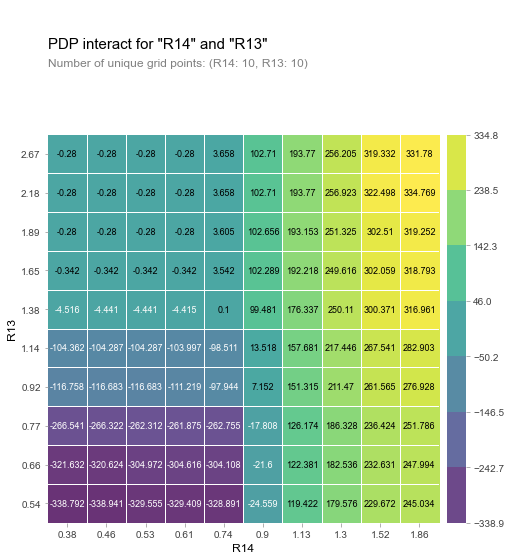

In [41]:
pdp_interact_plot(
    interaction_x, plot_type='grid',
    feature_names=[feature_x1,feature_x2]);

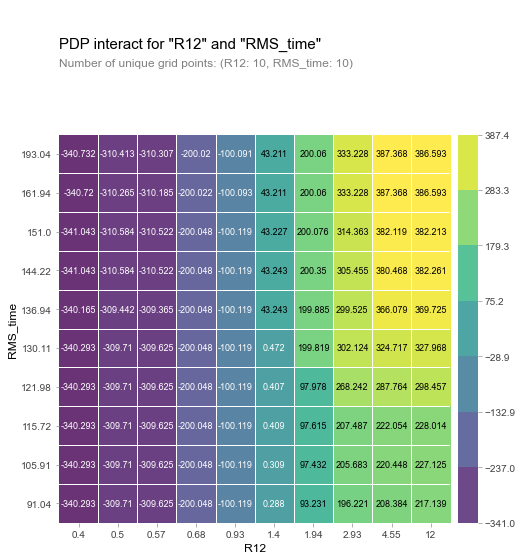

In [42]:
pdp_interact_plot(
    interaction_y, plot_type='grid',
    feature_names=[feature_y1,feature_y2]);

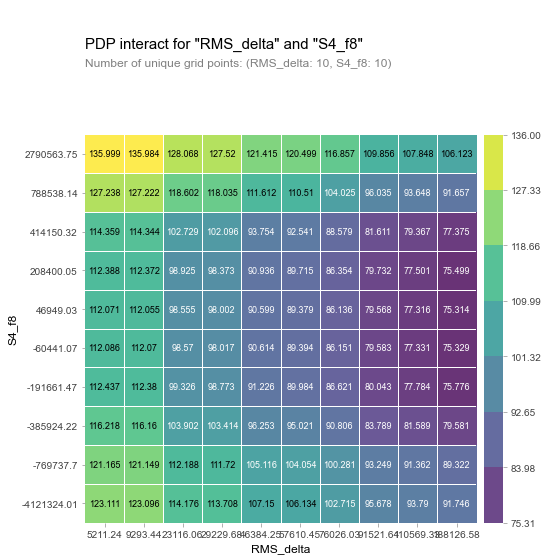

In [43]:
pdp_interact_plot(
    interaction_m, plot_type='grid',
    feature_names=[feature_m1,feature_m2]);

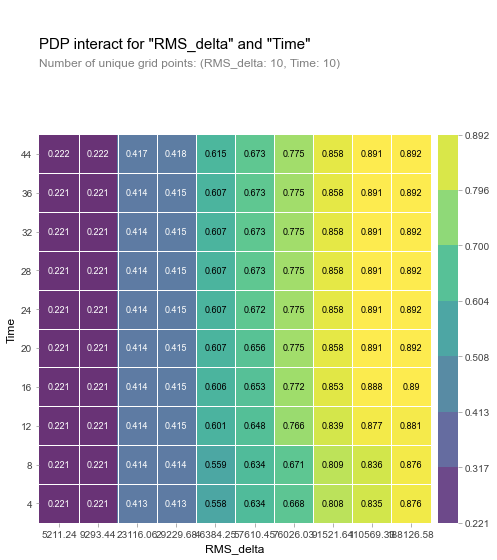

In [44]:
pdp_interact_plot(
    interaction_v, plot_type='grid',
    feature_names=[feature_v1,feature_v2]);